In [4]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize
from dataclasses import dataclass
import os

from sample4geo.dataset.soundingearth import SoundingEarthDatasetEval, SoundingEarthDatasetTrain
from torch.utils.data import DataLoader
from sample4geo.transforms import get_transforms_train_sat, get_transforms_train_spectro 
from sample4geo.transforms import get_transforms_val_sat, get_transforms_val_spectro 



@dataclass
class Configuration:
    img_size: int = 384         # for satallite images
    patch_time_steps = 512      # Image size for spectograms (Width)
    n_mels = 128                # image size for spectograms (Height)
    sr_kHz=48
    batch_size: int = 32         # keep in mind real_batch_size = 2 * batch_size
    data_folder = "data/SoundingEarth/data"   # Dataset
    # Augment Images
    prob_rotate: float = 0.75          # rotates the sat image 
    prob_flip: float = 0.5             # flipping the sat image 
    num_workers: int = 0 if os.name == 'nt' else 4 
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu' 
    

config = Configuration()

img_size = config.img_size
img_size_sat = (img_size, img_size)
img_size_spectro = (config.patch_time_steps, config.n_mels)

# Transforms
sat_transforms_train = get_transforms_train_sat(img_size_sat,
                                                                mean=[0.485, 0.456, 0.406],
                                                                std=[0.229, 0.224, 0.225],
                                                                )

spectro_transforms_train = get_transforms_train_spectro(img_size_spectro,
                                                                mean=[11.619702],        # calculated from 
                                                                std=[0.4910788],         #                 spectrogram data
                                                                )


train_dataset = SoundingEarthDatasetTrain(data_folder=config.data_folder ,
                                          split_csv='train_df.csv',
                                          transforms_sat_image=sat_transforms_train,
                                          transforms_spectrogram=spectro_transforms_train,
                                          patch_time_steps=config.patch_time_steps,
                                          sr_kHz=config.sr_kHz,
                                          n_mels=config.n_mels,
                                          prob_flip=config.prob_flip,
                                          prob_rotate=config.prob_rotate,
                                          shuffle_batch_size=config.batch_size
                                          )


train_dataloader = DataLoader(train_dataset,
                              batch_size=12,  
                              shuffle=True,
                              num_workers=config.num_workers,
                              pin_memory=True)

sat_transforms_val = get_transforms_val_sat(img_size_sat,
                                            mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225],
                                            )
# Eval
eval_dataset = SoundingEarthDatasetTrain(data_folder=config.data_folder ,  # using train as eval
                                          split_csv='test_df.csv',
                                          transforms_sat_image=sat_transforms_val,
                                          transforms_spectrogram=None,
                                          patch_time_steps=config.patch_time_steps,
                                          sr_kHz=config.sr_kHz,
                                          n_mels=config.n_mels,
                                          prob_flip=0,
                                          prob_rotate=0,
                                          shuffle_batch_size=config.batch_size
                                          )

eval_dataloader = DataLoader(eval_dataset,
                              batch_size=12,  
                              shuffle=True,
                              num_workers=config.num_workers,
                              pin_memory=True)
    

/home/j0kr0017/conda/lib/python3.12/site-packages/pydantic/main.py:328: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/home/j0kr0017/conda/lib/python3.12/site-packages/pydantic/main.py:328: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Plotte Train Dataloader Bilder

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


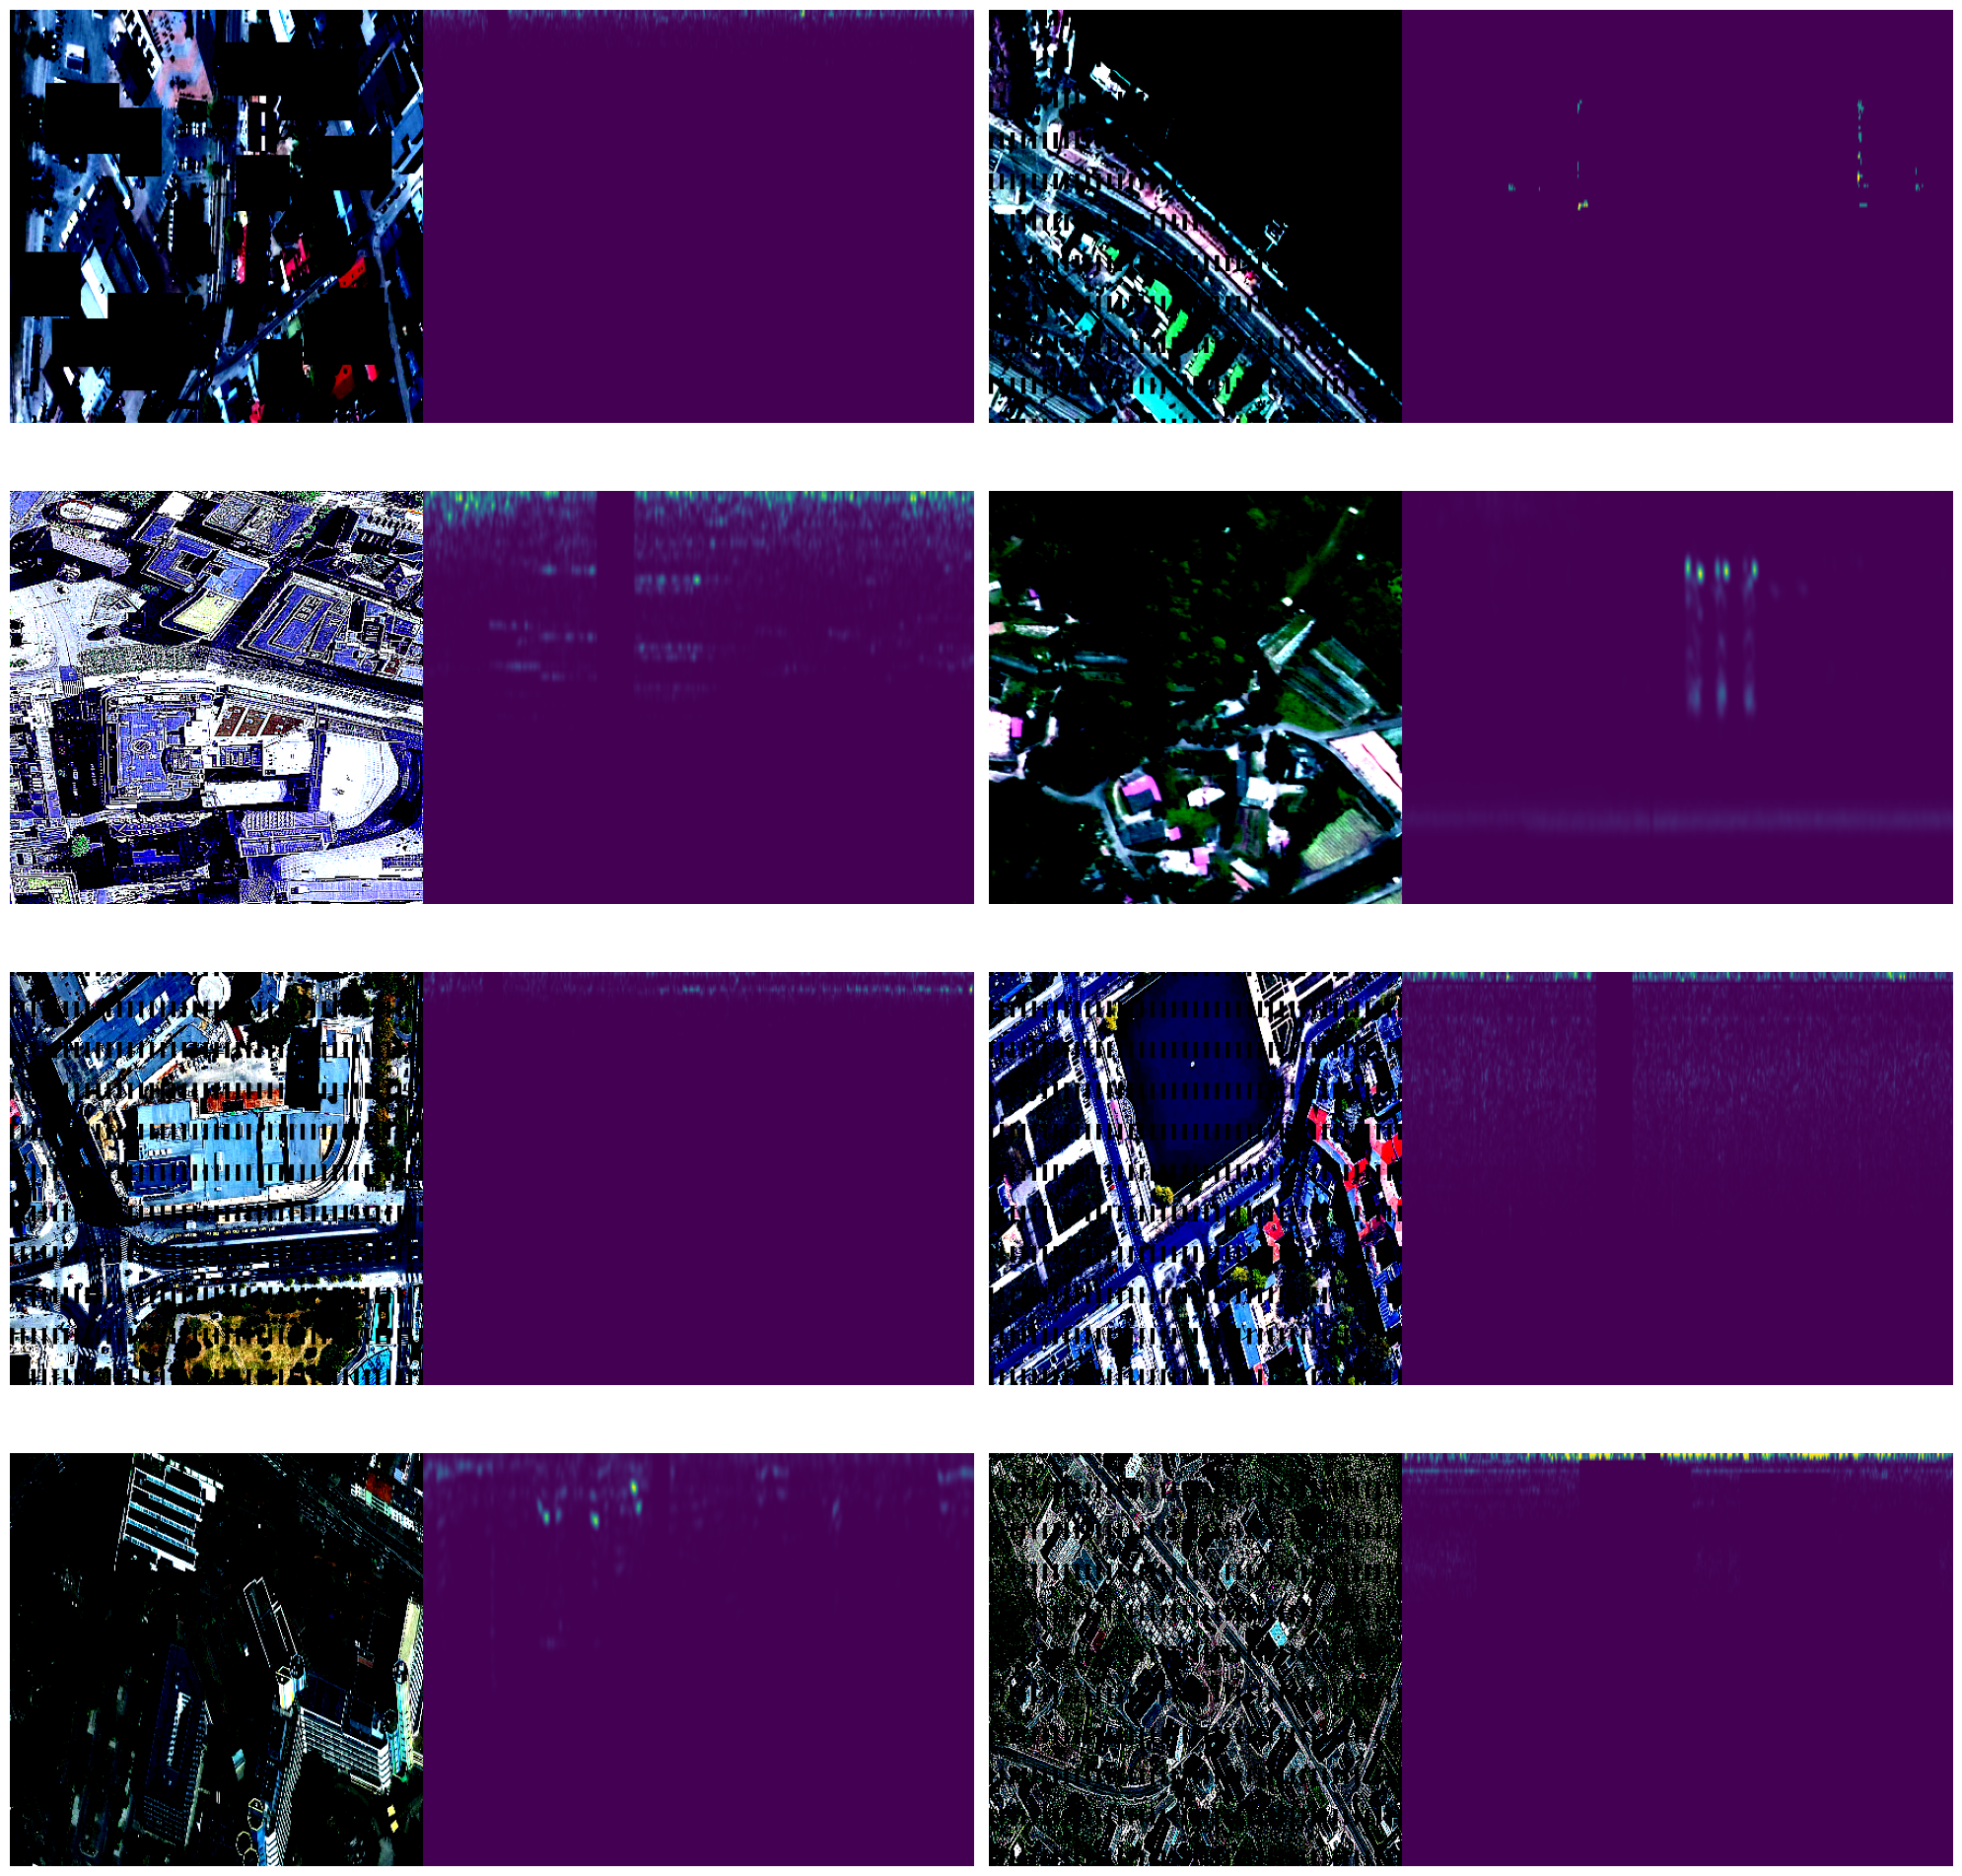

In [5]:
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(3, 1, 1).to(tensor.device)
    return tensor * std + mean

def plot_images(dataloader, num_images, mean=None, std=None):
    num_rows = (num_images + 1) // 2  
    fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 5 * num_rows))  
    axs = axs.flatten() 

    image_count = 0
    for data in dataloader:
        sat_images, spectrograms, _ = data  

        for sat_image, spectrogram in zip(sat_images, spectrograms):
            if image_count >= num_images:
                break

            if mean is not None and std is not None:
                sat_image = denormalize(sat_image, mean, std)

            target_height = sat_image.shape[1]  
            spectrogram_resized = resize(spectrogram, (target_height, spectrogram.shape[-1]))

            combined_image = torch.cat((sat_image, spectrogram_resized), dim=2)  

            ax = axs[image_count]
            ax.imshow(combined_image.permute(1, 2, 0).numpy())  
            ax.axis('off')  
            image_count += 1

        if image_count >= num_images:
            break

    plt.tight_layout()
    plt.show()

plot_images(train_dataloader, 8)

Plotte Eval Dataloader Bilder

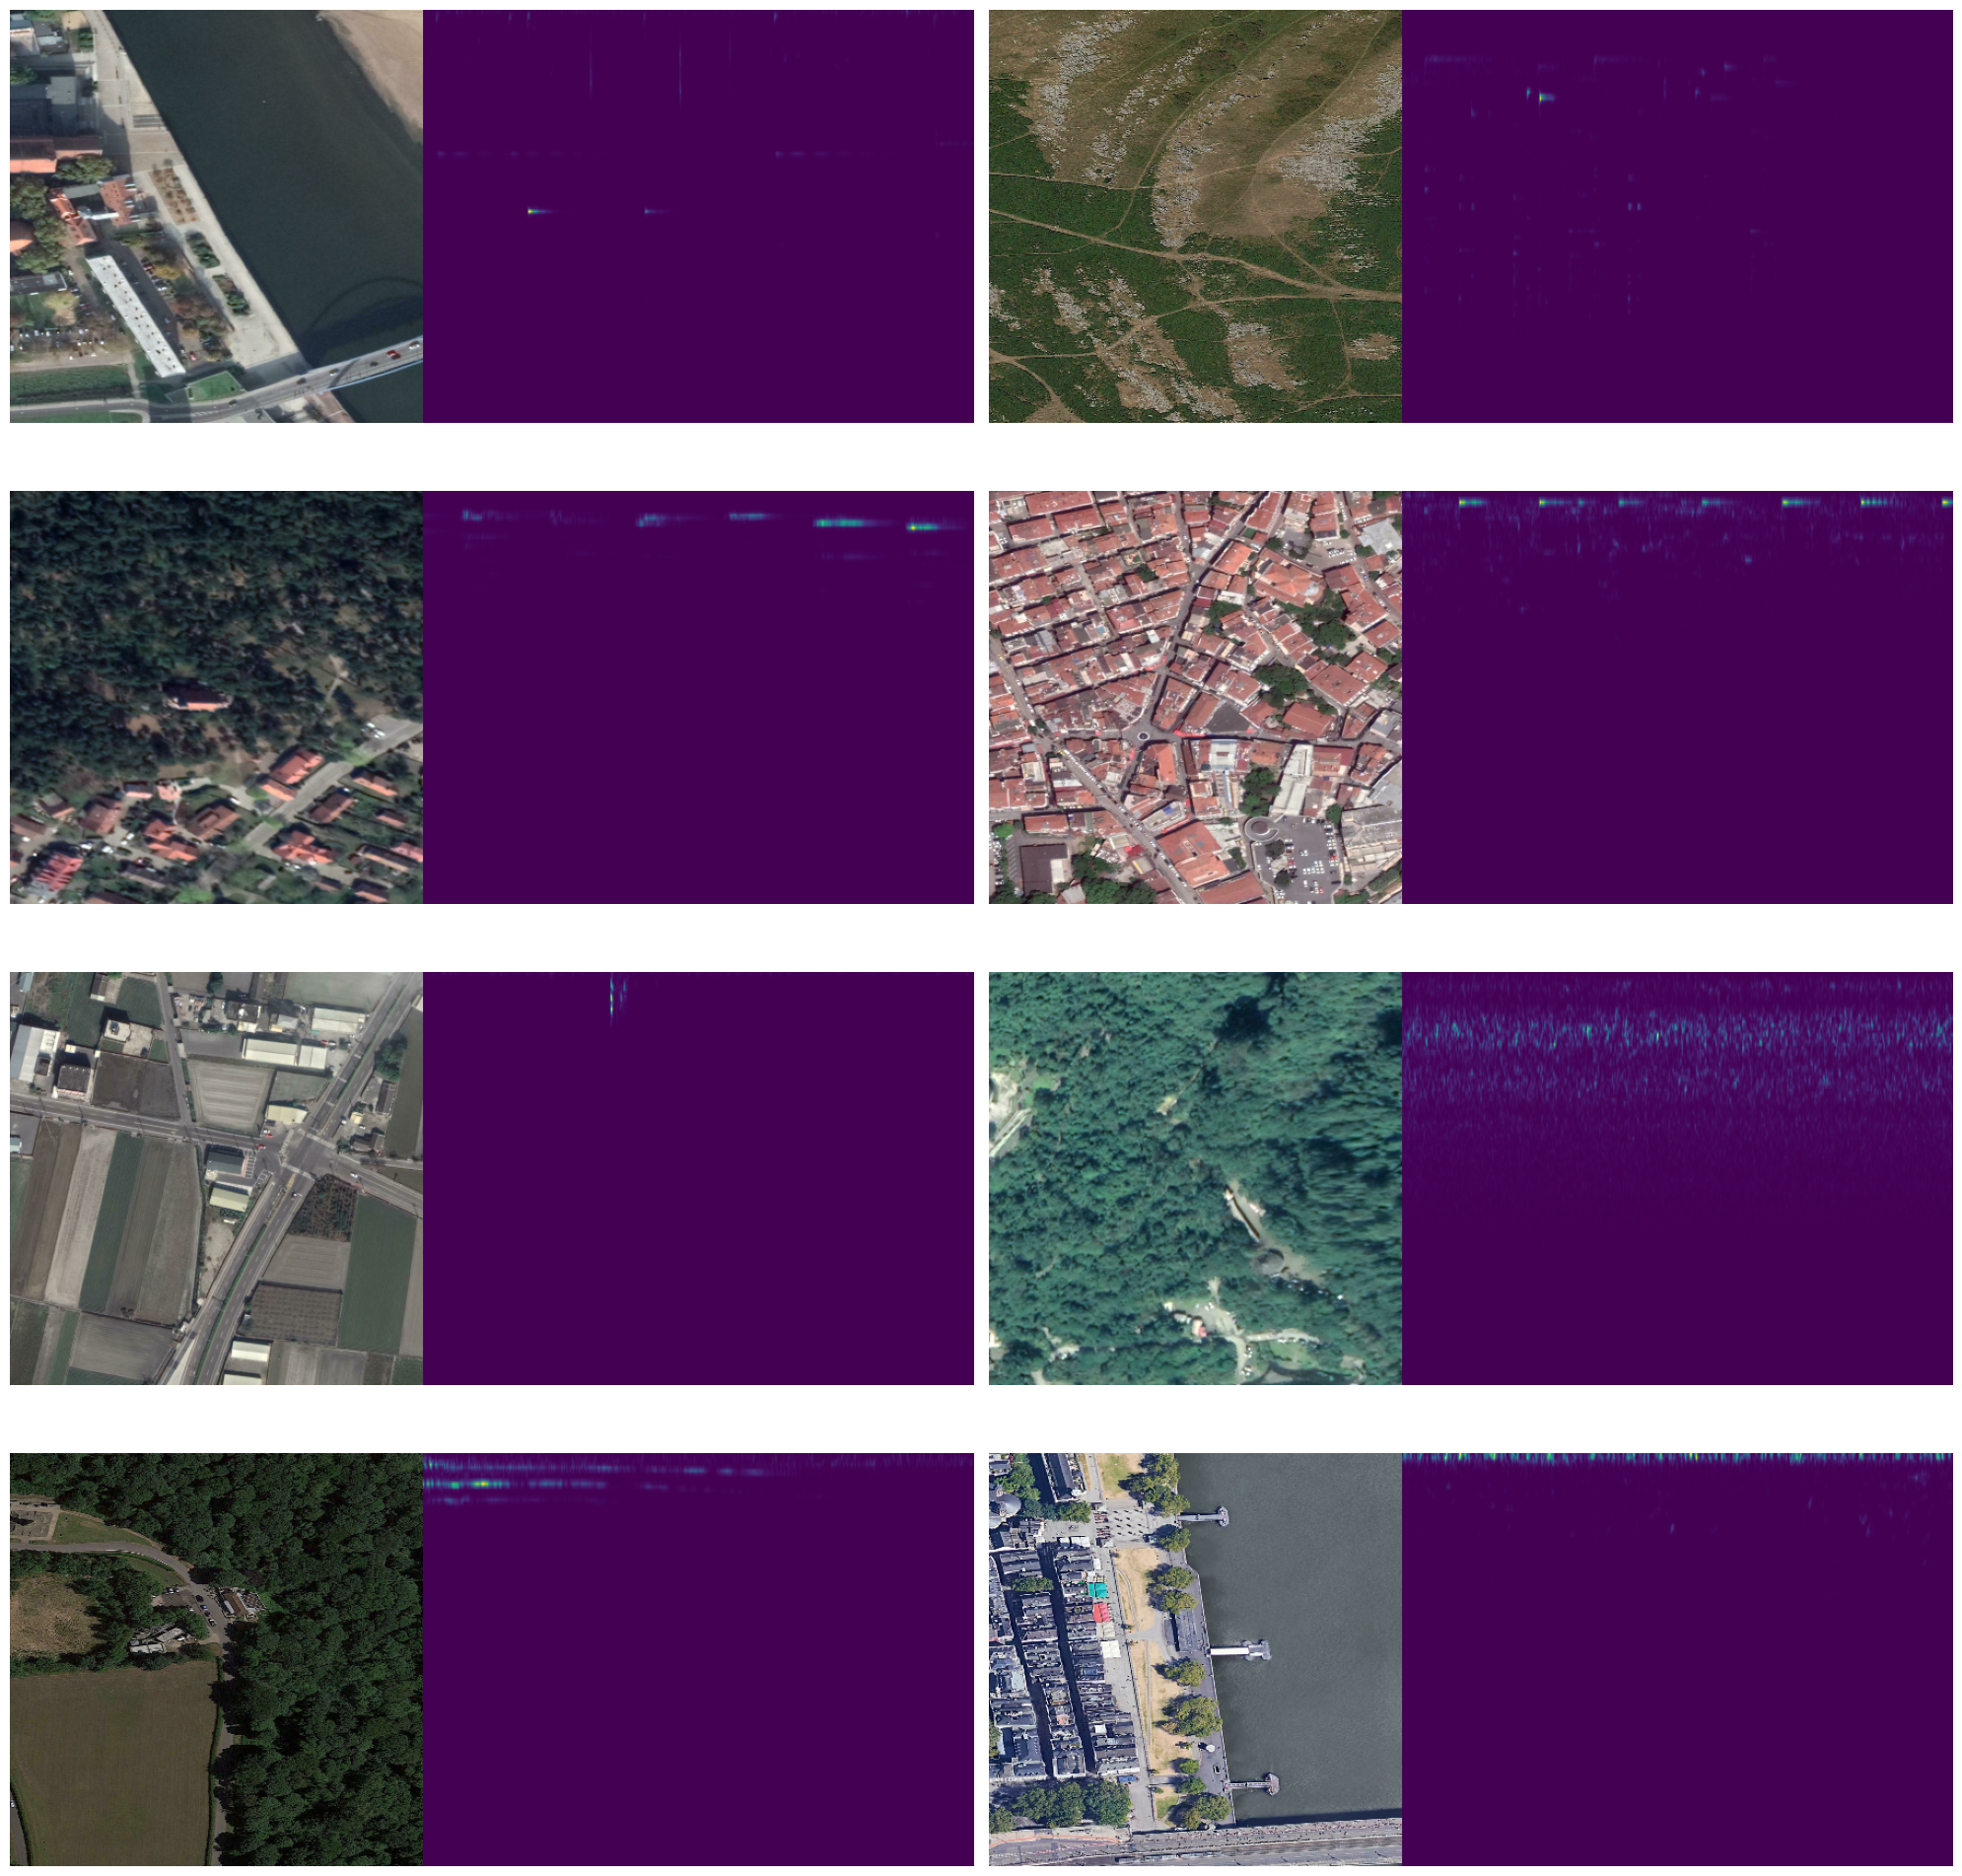

In [6]:
plot_images(eval_dataloader, 8, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])